# Creating a Dataset

#### Option 1 : rank by cov, var, and none

#### Option 2 : Using dask (for a large dataset)

In [1]:
from Dissertation import RandomGenerator, convert_to_int, get_order_index
rg = RandomGenerator(10, 10_000_000, order_by = 'var', use_dask = True)

dataset is ordered by var


/Users/gradcheckout/opt/anaconda3/lib/python3.9/site-packages/distributed/node.py:179: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53660 instead
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/57 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [2]:
config = rg._config

In [3]:
rg("sample_data")

http://127.0.0.1:53660/status


In [4]:
del rg

# Run a Tree Model

In [6]:
# open the file
import numpy as np
import pandas as pd
df = pd.read_parquet("sample_data")

In [7]:
df.index.name = None
df

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,y
0,1,1,1,1,1,1,1,1,1,0,-5.346832
1,1,1,1,1,0,1,1,0,0,0,-8.258515
2,0,1,1,1,0,0,0,0,0,0,-3.212571
3,1,0,1,1,1,1,1,0,1,0,-15.814381
4,1,1,1,1,1,0,0,1,0,0,-11.325643
...,...,...,...,...,...,...,...,...,...,...,...
9999995,1,1,1,1,1,1,1,1,1,0,0.745949
9999996,0,0,1,1,1,0,0,0,0,0,-8.981431
9999997,1,1,1,1,1,0,1,1,0,1,-4.051083
9999998,1,0,1,0,1,0,0,0,0,0,-2.792445


In [15]:
df['int'] = df.iloc[:, :10].apply(convert_to_int, axis = 1)

<AxesSubplot:ylabel='Frequency'>

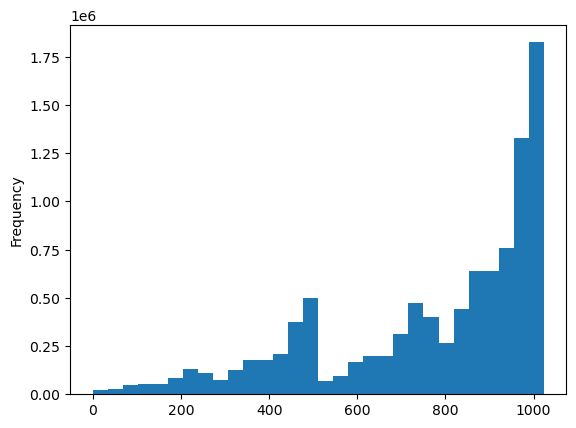

In [16]:
df['int'].plot.hist(bins = 30)

In [19]:
num_unique = df['int'].unique().shape[0]

In [20]:
num_unique

1024

In [21]:
2**10

1024

In [157]:
q = .5
count_statistics = (df.groupby('int')['y'].count().quantile([.25,.3,.4,.5,.55,.6,.65, .7,.8,.9])//1).astype(int)

In [158]:
count_statistics

0.25     2276
0.30     2593
0.40     3327
0.50     4938
0.55     6222
0.60     7228
0.65     8201
0.70     9246
0.80    13182
0.90    24336
Name: y, dtype: int64

In [173]:
?np.arange

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 ])

In [198]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

# parameters = {'min_samples_split':count_statistics.tolist(),
#              'ccp_alpha': np.arange(0,.35, .05)}

parameters = {'ccp_alpha': np.arange(0,.05, .005)}
reg= DecisionTreeRegressor()
clf = GridSearchCV(reg, parameters, verbose = 3, n_jobs = -1)
# clf.fit(iris.data, iris.target)


# sorted(clf.cv_results_.keys())

In [200]:
clf

GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             verbose=3)

In [201]:
X = df[['int']]
y = df[['y']]

In [202]:
clf.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045])},
             verbose=3)

In [203]:
clf.cv_results_['mean_test_score']

array([0.69093044, 0.68307475, 0.67444493, 0.66755453, 0.66107797,
       0.65515194, 0.6495817 , 0.64208041, 0.63475838, 0.63073381])

In [229]:
from itertools import product
n = 10
lst = list(product([0, 1], repeat=n))
test = np.arange(2**10).reshape(-1,1)

In [262]:
def find_n_groups(ccp_alpha, X, y, test):
    reg = DecisionTreeRegressor(ccp_alpha = ccp_alpha)
    reg.fit(X, y)
    r_sq = reg.score(X, y)
    result = reg.predict(test)
    num_groups = len(np.unique(result))
    return r_sq, num_groups

In [263]:
from functools import partial
find_n_groups_by_ccp_alpha = partial(find_n_groups, X = X.to_numpy(), y = y, test = test)

In [264]:
parameters = np.arange(0, .05, .005)

In [265]:
r2, n = find_n_groups_by_ccp_alpha(0.05)

In [268]:
r_sq = []
n_groups = []
for i in parameters:
    print(f"ccp_alpha is {i}")
    r2, n = find_n_groups_by_ccp_alpha(i)
    r_sq.append(r2); n_groups.append(n)


ccp_alpha is 0.0
ccp_alpha is 0.005
ccp_alpha is 0.01
ccp_alpha is 0.015
ccp_alpha is 0.02
ccp_alpha is 0.025
ccp_alpha is 0.03
ccp_alpha is 0.035
ccp_alpha is 0.04
ccp_alpha is 0.045


In [290]:
F = (r_sq[0]-r_sq[1])/(1-r_sq[0])*(X.shape[0]-n_groups[0])/(n_groups[0]-n_groups[1])

In [309]:
r_sq

[0.6910021457389746,
 0.683072514244302,
 0.6740931958923755,
 0.6676447273751747,
 0.6611791246989169,
 0.6552237922806954,
 0.6496959137534006,
 0.6416992285063086,
 0.6349342730060381,
 0.6307109261168593]

In [279]:
n_groups

[1024, 381, 282, 240, 210, 189, 172, 152, 137, 129]

In [301]:
r_sq[n_groups.index(189)]

0.6552237922806954

In [304]:
config.keys()

dict_keys(['p', 'sample size', 'interactions', 'bernoulli parameters', 'coefficients'])

In [302]:
(r_sq[0]-r_sq[1])/(1-r_sq[0])

0.025662416050222712

In [291]:
from scipy.stats import f
dfn, dfd = (X.shape[0]-n_groups[0]), (n_groups[0]-n_groups[1])

In [292]:
dfn, dfd

(9998976, 643)

In [294]:
1- f.cdf(F, dfn, dfd)

1.1102230246251565e-16

In [297]:
len(config['coefficients'])

180

In [234]:
num_groups = []
for ccp_alpha in np.arange(0,.05, .005):
    reg = DecisionTreeRegressor(ccp_alpha = ccp_alpha)
    reg.fit(X, y)
    result = reg.predict(test)
    num_groups.append(len(np.unique(result)))

TypeError: __init__() got an unexpected keyword argument 'n_jobs'

In [231]:
reg = DecisionTreeRegressor(ccp_alpha = .3)
reg.fit(X, y)
result = reg.predict(test)


/Users/gradcheckout/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


In [233]:
len(np.unique(result))

25

In [204]:
clf.cv_results_['std_test_score']

array([0.00026513, 0.00034555, 0.00047058, 0.00023911, 0.00045846,
       0.00026175, 0.00056715, 0.00086697, 0.00120578, 0.00044969])

[CV 1/5] END .....................ccp_alpha=0.0;, score=0.691 total time=  12.8s
[CV 2/5] END .....................ccp_alpha=0.1;, score=0.587 total time=  13.7s
[CV 2/5] END .....................ccp_alpha=0.2;, score=0.534 total time=  13.7s
[CV 2/5] END .....ccp_alpha=0.30000000000000004;, score=0.469 total time=   8.7s
[CV 5/5] END .....................ccp_alpha=0.0;, score=0.691 total time=  13.7s
[CV 1/5] END ....................ccp_alpha=0.01;, score=0.674 total time=  13.6s
[CV 1/5] END ....................ccp_alpha=0.02;, score=0.661 total time=  13.7s
[CV 1/5] END ....................ccp_alpha=0.03;, score=0.649 total time=  13.9s
[CV 1/5] END ....................ccp_alpha=0.04;, score=0.634 total time=  13.0s
[CV 4/5] END .....................ccp_alpha=0.0;, score=0.691 total time=  12.8s
[CV 3/5] END .....................ccp_alpha=0.1;, score=0.589 total time=  14.1s
[CV 3/5] END .....................ccp_alpha=0.2;, score=0.534 total time=  13.7s
[CV 3/5] END .....ccp_alpha=

In [187]:
# reg= DecisionTreeRegressor(min_samples_split= 24336)
reg = DecisionTreeRegressor(ccp_alpha = .05)
reg.fit(X, y)

DecisionTreeRegressor(ccp_alpha=0.05)

In [188]:
df['pred_tree'] = reg.predict(X)

In [189]:
group_map = dict(zip(np.sort(df.pred_tree.unique()), range(df.pred_tree.unique().shape[0])))
df['tree_group'] = df.pred_tree.apply(lambda x: group_map[x])

In [190]:
df.head()

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,y,int,pred_tree,tree_group
0,1,1,1,1,1,1,1,1,1,0,-5.346832,1022,-1.734549,88
1,1,1,1,1,0,1,1,0,0,0,-8.258515,984,-9.223353,46
2,0,1,1,1,0,0,0,0,0,0,-3.212571,448,-2.148693,85
3,1,0,1,1,1,1,1,0,1,0,-15.814381,762,-16.738607,19
4,1,1,1,1,1,0,0,1,0,0,-11.325643,996,-6.414577,57


<AxesSubplot:ylabel='Frequency'>

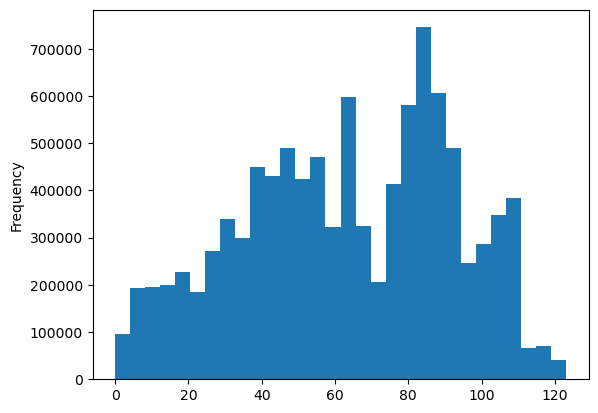

In [191]:
df.tree_group.plot.hist(bins = 30)

In [192]:
df.tree_group.max()

123

In [193]:
df.tree_group.max()/2**10

0.1201171875

In [8]:
class modelConfig:
    def __init__(self, **kwargs):
        self.hello = kwargs['hello']


In [9]:
modelConfig({'hello':0})

TypeError: __init__() takes 1 positional argument but 2 were given